In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

2022-11-12 18:13:21.715950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 18:13:21.842130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 18:13:21.842155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-12 18:13:21.870443: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-12 18:13:22.372054: W tensorflow/stream_executor/platform/de

In [2]:
seed = 2
np.random.seed(seed)

# Monk1 #

Loading data for Monk1

In [3]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
monk1_tr = pd.read_csv("./dataset/monk1/monks-1.train", sep = " ", skipinitialspace=True, names = colnames)
monk1_tr = monk1_tr.drop('id', axis = 1)

monk1_ts = pd.read_csv("./dataset/monk1/monks-1.test", sep = " ", skipinitialspace=True, names = colnames)
monk1_ts = monk1_ts.drop('id', axis = 1)

Division of the sets into target set and input set

In [4]:
x_monk1_tr = monk1_tr.iloc[:, 1:7].values
y_monk1_tr = monk1_tr.iloc[:, 0].values
x_monk1_ts = monk1_ts.iloc[:, 1:7].values
y_monk1_ts = monk1_ts.iloc[:, 0].values

Perform a one-hot-encoding for each tests' attributes

In [5]:
one_hot_encoder_tr = OneHotEncoder(sparse=False)
one_hot_encoder_tr.fit(x_monk1_tr)
x_monk1_tr = one_hot_encoder_tr.transform(x_monk1_tr)

one_hot_encoder_ts = OneHotEncoder(sparse=False)
one_hot_encoder_ts.fit(x_monk1_ts)
x_monk1_ts = one_hot_encoder_ts.transform(x_monk1_ts)

x_monk1_tr, y_monk1_tr = shuffle(x_monk1_tr, y_monk1_tr)
x_monk1_ts, y_monk1_ts = shuffle(x_monk1_ts, y_monk1_ts)

So now the number of columns of our matrices passed from 6 to 17.

Let us now divide the design set into the training set and the validation test

In [6]:
subset_size = int(0.3 * len(x_monk1_tr))

index = np.random.choice(len(x_monk1_tr), subset_size, replace=False)
index = np.sort(index)

x_monk1_vl = x_monk1_tr[index]
y_monk1_vl = y_monk1_tr[index]

x_monk1_tr = np.delete(x_monk1_tr, index, 0)
y_monk1_tr = np.delete(y_monk1_tr, index, 0)

CELLA SOTTO È DA BUTTARE 

In [7]:
"""cv = model_selection.KFold(5)
val_losses = []
print(len())
for train_indices, test_indices in cv.split(x_monk1_tr):
    x_junk, x_junk2 = x_monk1_tr[train_indices], x_monk1_tr[test_indices]
    y_junk, y_junk2 = y_monk1_tr[train_indices], y_monk1_tr[test_indices]
    print(len(x_junk), len(y_junk))"""

'cv = model_selection.KFold(5)\nval_losses = []\nprint(len())\nfor train_indices, test_indices in cv.split(x_monk1_tr):\n    x_junk, x_junk2 = x_monk1_tr[train_indices], x_monk1_tr[test_indices]\n    y_junk, y_junk2 = y_monk1_tr[train_indices], y_monk1_tr[test_indices]\n    print(len(x_junk), len(y_junk))'

In [8]:
subset_size = int(1.0 * len(x_monk1_tr))

index = np.random.choice(len(x_monk1_tr), subset_size, replace=False)
index

array([54, 66, 14,  7, 63, 55,  5, 33,  9, 36, 32, 62, 53, 42, 68, 41, 77,
       38, 83, 61, 60, 20, 44, 31, 70, 43,  0, 67, 17, 18, 74, 45, 80, 85,
       15, 56, 86, 37, 65, 76, 84, 12, 30, 69, 48, 22, 11, 58, 78, 10, 29,
       73, 40, 72, 79, 59, 21, 47,  6, 82,  3,  8, 27,  4, 81, 25, 23, 46,
       75, 49, 19, 28, 13, 34, 52, 26, 16, 24, 71,  1, 64, 35, 57, 50, 51,
        2, 39])

## Creating the model ##

Now we will use KerasTuner to find the best hyperparameters for the model selection phase.

In [9]:
def build_model(hp) :
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units", min_value=3, max_value=11, step=2),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("learning_rate", min_value=0.1, max_value=1.0, step=0.05)
    momentum = hp.Float("momentum", min_value=0.0, max_value=0.9, step=0.05)
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(
        optimizer=opt, loss='mse', metrics=['accuracy']
    )
    return model

In [10]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory="results/monk1",
    project_name="nn_RandomSearch/par_hp",
)

2022-11-12 18:13:23.543121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-12 18:13:23.543144: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-12 18:13:23.543162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-11-12 18:13:23.543405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Brief summary of the search space

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 11, 'step': 2, 'sampling': None}
learning_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 1.0, 'step': 0.05, 'sampling': None}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.05, 'sampling': None}


In [12]:
tuner.search(
    x_monk1_tr, y_monk1_tr, 
    epochs=200, 
    validation_data=(x_monk1_vl, y_monk1_vl)
)

Trial 100 Complete [00h 00m 15s]
val_accuracy: 0.9054054021835327

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 24m 02s
INFO:tensorflow:Oracle triggered exit


The results have been saved, now let's take a look to the results

In [13]:
best_hp = tuner.get_best_hyperparameters(3)

for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

best hyperparameters n. 0
units 5
learning_rate 0.6000000000000002
momentum 0.6000000000000001

best hyperparameters n. 1
units 5
learning_rate 0.6000000000000002
momentum 0.2

best hyperparameters n. 2
units 3
learning_rate 0.8000000000000002
momentum 0.15000000000000002



In [14]:
f_model = build_model(best_hp[0])
f_model.build(input_shape=(None, 17))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 90        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [15]:
tuner.results_summary()

Results summary
Results in results/monk1/nn_RandomSearch/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.6000000000000002
momentum: 0.6000000000000001
Score: 1.0
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.6000000000000002
momentum: 0.2
Score: 0.9864864945411682
Trial summary
Hyperparameters:
units: 3
learning_rate: 0.8000000000000002
momentum: 0.15000000000000002
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.30000000000000004
momentum: 0.15000000000000002
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 9
learning_rate: 0.9500000000000003
momentum: 0.25
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.8500000000000002
momentum: 0.7000000000000001
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 3
learning_rate: 0.6000000000000002
momentum: 0.6000000000000001
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 9
learning_rate: 0

In [16]:
n_hp = len(best_hp)
n_trials = 5

models = [None]*n_hp
for i in range(n_hp):
    models[i] = [None]*n_trials

for i in range(n_hp):
    for j in range(n_trials):
        models[i][j] = build_model(best_hp[i])

x_monk1_ds = np.concatenate((x_monk1_tr, x_monk1_vl))
y_monk1_ds = np.concatenate((y_monk1_tr, y_monk1_vl))

n_epochs = 200
hist = [None]*n_hp
for i in range(n_hp):
    hist[i] = [None]*n_trials

for i in range(n_hp):
    for j in range(n_trials):
        hist[i][j] = models[i][j].fit(x=x_monk1_ds, y=y_monk1_ds, epochs=n_epochs)

Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2647 - accuracy: 0.4516
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.5645
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2326 - accuracy: 0.6048
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.6532
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.6855
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2024 - accuracy: 0.6935
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.7258
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.7742
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1672 - accuracy: 0.7742
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.7984
Epoch 11/200
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 85/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 88/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 89/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 90/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 91/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 93/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 9.6463e-04 - accuracy: 1.0000
Epoch 167/200
4/4 [==============================] - 0s 2ms/step - loss: 9.5531e-04 - accuracy: 1.0000
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 9.4459e-04 - accuracy: 1.0000
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 9.4115e-04 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 9.3025e-04 - accuracy: 1.0000
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 9.2291e-04 - accuracy: 1.0000
Epoch 172/200
4/4 [==============================] - 0s 3ms/step - loss: 9.1345e-04 - accuracy: 1.0000
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 9.0712e-04 - accuracy: 1.0000
Epoch 174/200
4/4 [==============================] - 0s 2ms/step - loss: 8.9842e-04 - accuracy: 1.0000
Epoch 175/200
4/4 [==============================] - 0s 2ms/step - loss: 8.8924e-04 - a

4/4 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9355
Epoch 49/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9355
Epoch 50/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9355
Epoch 51/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9355
Epoch 52/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0453 - accuracy: 0.9355
Epoch 53/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9355
Epoch 54/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9355
Epoch 55/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9355
Epoch 56/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9355
Epoch 57/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9355
Epoch 58/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 132/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 133/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 134/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 137/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 138/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 139/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 140/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 141/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0937 - accuracy: 0.9355
Epoch 14/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0878 - accuracy: 0.9274
Epoch 15/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9355
Epoch 16/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0787 - accuracy: 0.9355
Epoch 17/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9516
Epoch 18/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9516
Epoch 19/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9435
Epoch 20/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9597
Epoch 21/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9516
Epoch 22/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9516
Epoch 23/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 97/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 98/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 99/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 100/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 102/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 103/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 104/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 105/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 106/200
4/4 [========

4/4 [==============================] - 0s 2ms/step - loss: 8.8287e-04 - accuracy: 1.0000
Epoch 179/200
4/4 [==============================] - 0s 2ms/step - loss: 8.7356e-04 - accuracy: 1.0000
Epoch 180/200
4/4 [==============================] - 0s 2ms/step - loss: 8.6681e-04 - accuracy: 1.0000
Epoch 181/200
4/4 [==============================] - 0s 2ms/step - loss: 8.6308e-04 - accuracy: 1.0000
Epoch 182/200
4/4 [==============================] - 0s 2ms/step - loss: 8.5570e-04 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 8.5380e-04 - accuracy: 1.0000
Epoch 184/200
4/4 [==============================] - 0s 2ms/step - loss: 8.4438e-04 - accuracy: 1.0000
Epoch 185/200
4/4 [==============================] - 0s 2ms/step - loss: 8.3794e-04 - accuracy: 1.0000
Epoch 186/200
4/4 [==============================] - 0s 2ms/step - loss: 8.3123e-04 - accuracy: 1.0000
Epoch 187/200
4/4 [==============================] - 0s 2ms/step - loss: 8.2476e-04 - a

4/4 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 61/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 62/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 63/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 64/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 65/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 66/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 67/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 68/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 69/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 70/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 144/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 145/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 146/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 147/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 148/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 149/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 150/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 151/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 152/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 153/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.9274
Epoch 25/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.9355
Epoch 26/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9274
Epoch 27/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9355
Epoch 28/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9355
Epoch 29/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9355
Epoch 30/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9597
Epoch 31/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9597
Epoch 32/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9839
Epoch 33/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9839
Epoch 34/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 108/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 109/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 110/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 111/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 112/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 113/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 114/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 115/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 116/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 117/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.9211e-04 - accuracy: 1.0000
Epoch 189/200
4/4 [==============================] - 0s 2ms/step - loss: 7.8528e-04 - accuracy: 1.0000
Epoch 190/200
4/4 [==============================] - 0s 2ms/step - loss: 7.7915e-04 - accuracy: 1.0000
Epoch 191/200
4/4 [==============================] - 0s 3ms/step - loss: 7.7198e-04 - accuracy: 1.0000
Epoch 192/200
4/4 [==============================] - 0s 3ms/step - loss: 7.6634e-04 - accuracy: 1.0000
Epoch 193/200
4/4 [==============================] - 0s 3ms/step - loss: 7.6005e-04 - accuracy: 1.0000
Epoch 194/200
4/4 [==============================] - 0s 3ms/step - loss: 7.5482e-04 - accuracy: 1.0000
Epoch 195/200
4/4 [==============================] - 0s 3ms/step - loss: 7.4856e-04 - accuracy: 1.0000
Epoch 196/200
4/4 [==============================] - 0s 2ms/step - loss: 7.4322e-04 - accuracy: 1.0000
Epoch 197/200
4/4 [==============================] - 0s 3ms/step - loss: 7.3772e-04 - a

4/4 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9919
Epoch 72/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9919
Epoch 73/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9919
Epoch 74/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9919
Epoch 75/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 1.0000
Epoch 76/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 1.0000
Epoch 77/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 1.0000
Epoch 78/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 1.0000
Epoch 79/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 1.0000
Epoch 80/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 1.0000
Epoch 81/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 155/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 156/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 157/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 158/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 159/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 160/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 161/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 162/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 163/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 164/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9274
Epoch 38/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.9435
Epoch 39/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9435
Epoch 40/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9435
Epoch 41/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9516
Epoch 42/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9597
Epoch 43/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9597
Epoch 44/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9677
Epoch 45/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9597
Epoch 46/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9758
Epoch 47/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 121/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 122/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 123/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 124/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 125/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 126/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 127/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 128/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 129/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 130/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.2477 - accuracy: 0.5242
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2417 - accuracy: 0.5806
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.6048
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.5968
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.6532
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.7177
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.7823
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.7742
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.8306
Epoch 11/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.8226
Epoch 12/200
4/4 [======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 88/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 89/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 90/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 91/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 93/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 94/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 95/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 172/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 174/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 175/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 176/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 177/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 178/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9919
Epoch 52/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9919
Epoch 53/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 1.0000
Epoch 54/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 1.0000
Epoch 55/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 1.0000
Epoch 56/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 1.0000
Epoch 57/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0402 - accuracy: 1.0000
Epoch 58/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 1.0000
Epoch 59/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 1.0000
Epoch 60/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 1.0000
Epoch 61/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 137/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 138/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 139/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 140/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 141/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 142/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 143/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 144/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.8629
Epoch 18/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.8710
Epoch 19/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1056 - accuracy: 0.8952
Epoch 20/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.8871
Epoch 21/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0979 - accuracy: 0.8871
Epoch 22/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0944 - accuracy: 0.9032
Epoch 23/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0917 - accuracy: 0.8790
Epoch 24/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9032
Epoch 25/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.8952
Epoch 26/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9113
Epoch 27/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 102/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 103/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 104/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 105/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 106/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 107/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 108/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 109/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 110/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 184/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 185/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 186/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 187/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 188/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 189/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 190/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 191/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 192/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9516
Epoch 66/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9597
Epoch 67/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9597
Epoch 68/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9597
Epoch 69/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.9597
Epoch 70/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.9597
Epoch 71/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9597
Epoch 72/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.9597
Epoch 73/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9597
Epoch 74/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.9597
Epoch 75/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9597
Epoch 149/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9597
Epoch 150/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9597
Epoch 151/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9597
Epoch 152/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9597
Epoch 153/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9597
Epoch 154/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9597
Epoch 155/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9597
Epoch 156/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9597
Epoch 157/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9597
Epoch 158/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9516
Epoch 32/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9597
Epoch 33/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9677
Epoch 34/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9597
Epoch 35/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9839
Epoch 36/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9839
Epoch 37/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9919
Epoch 38/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9839
Epoch 39/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 1.0000
Epoch 40/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 1.0000
Epoch 41/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 115/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 116/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 117/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 118/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 119/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 120/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 121/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 122/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 123/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 124/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 197/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 198/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 199/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.5645
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2364 - accuracy: 0.6129
Epoch 3/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2160 - accuracy: 0.7097
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2027 - accuracy: 0.7419
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.7984
Epoch 6/200
4/4 [=================

4/4 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 80/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 81/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 82/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 83/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 84/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 85/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 88/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 89/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 163/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 164/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 165/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 166/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 167/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 172/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9677
Epoch 46/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9839
Epoch 47/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0438 - accuracy: 0.9839
Epoch 48/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9839
Epoch 49/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0371 - accuracy: 0.9839
Epoch 50/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9839
Epoch 51/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0324 - accuracy: 0.9919
Epoch 52/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9919
Epoch 53/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0299 - accuracy: 1.0000
Epoch 54/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 1.0000
Epoch 55/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 129/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 130/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 131/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 132/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 133/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 134/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 137/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 138/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.7339
Epoch 12/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1896 - accuracy: 0.7339
Epoch 13/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.7984
Epoch 14/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1653 - accuracy: 0.8226
Epoch 15/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.8226
Epoch 16/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.8387
Epoch 17/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.8629
Epoch 18/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1211 - accuracy: 0.8871
Epoch 19/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1119 - accuracy: 0.9274
Epoch 20/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9274
Epoch 21/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 95/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 96/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 97/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 98/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 99/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 100/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 102/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 103/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 104/200
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 177/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 178/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 179/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 180/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 181/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 182/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 184/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 185/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 186/200
4/4 [=====

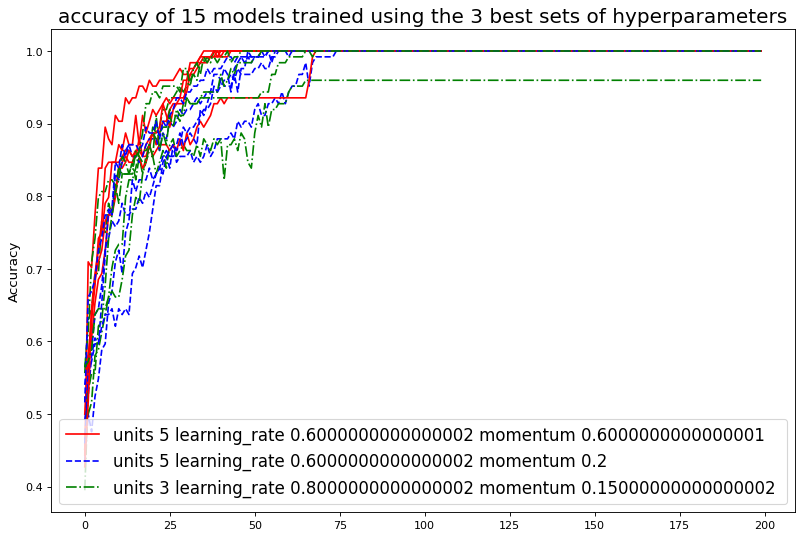

In [17]:
labels = [None]*n_hp
for i in range(n_hp):
    labels[i] = ""
    for h_param in ["units", "learning_rate", "momentum"]:
        labels[i] += h_param + " " + str(best_hp[i].get(h_param)) + " "

colours = ["red", "blue", "green", "purple", "olive", "grey"]
linestyles = ["solid", "dashed", "dashdot", "dotted", (0, (1,1)), (5, (5, 10))]

plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials):
    for j in range(n_hp):
        plt.plot(hist[j][i].history['accuracy'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "accuracy of " + str(n_hp*n_trials) + " models trained using the " + str(n_hp) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Accuracy", size=12)
plt.legend(labels, prop={'size': 15})
plt.savefig("./plots/monk1/nn_RandomSearch/ms_accuracy.png")
plt.show()

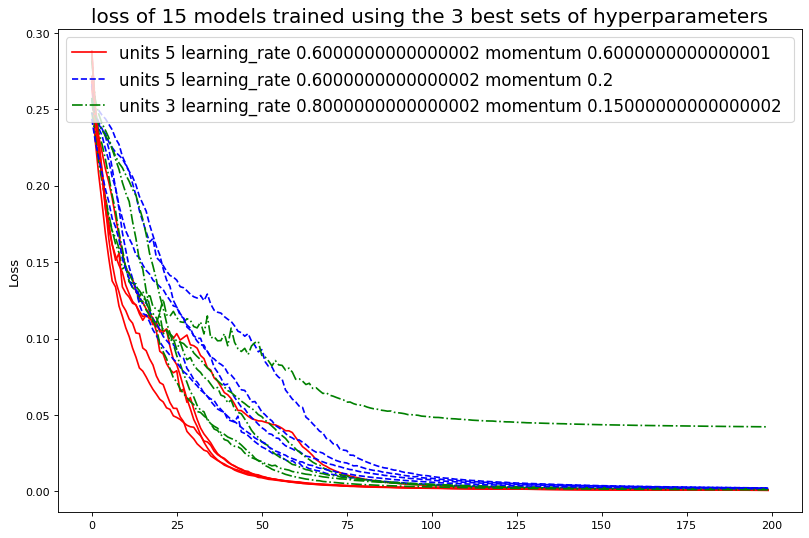

In [35]:
plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials):
    for j in range(n_hp):
        plt.plot(hist[j][i].history['loss'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "loss of " + str(n_hp*n_trials) + " models trained using the " + str(n_hp) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Loss", size=12)
plt.legend(labels, prop={'size': 15})
plt.savefig("./plots/monk1/nn_RandomSearch/ms_loss.png")
plt.show()

In [19]:
print("Final accuracy reached for each of the " + str(n_hp*n_trials) + " models\n")

for i in range(n_hp):
    print("set of hyperparameters n." + str(i) + ": " + labels[i])
    for j in range(n_trials):
        print(hist[i][j].history['accuracy'][n_epochs - 1], end=" - ")
    print("\n")

Final accuracy reached for each of the 15 models

set of hyperparameters n.0: units 5 learning_rate 0.6000000000000002 momentum 0.6000000000000001 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.1: units 5 learning_rate 0.6000000000000002 momentum 0.2 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.2: units 3 learning_rate 0.8000000000000002 momentum 0.15000000000000002 
0.9596773982048035 - 1.0 - 1.0 - 1.0 - 1.0 - 



In [20]:
acc = None
best_acc = -1.0
best_model = None

for i in range(n_hp):
    for j in range(n_trials):
        acc = hist[i][j].history['accuracy'][n_epochs - 1]
        if (acc > best_acc):
            best_acc = acc
            best_model = models[i][j]
            
best_model.save("results/monk1/nn_RandomSearch/final_model/")

INFO:tensorflow:Assets written to: results/monk1/nn_RandomSearch/final_model/assets


here it finishes the phase of model selection

## Model Assessment ##

In [21]:
score = best_model.evaluate(x_monk1_ts, y_monk1_ts)

14/14 [==============================] - 0s 944us/step - loss: 0.0027 - accuracy: 1.0000


In [22]:
print(
    "Final error (MSE) on the test set: " + str(score[0]) + "\n" +
    "Final accuracy on the test set: " + str(score[1])
)

Final error (MSE) on the test set: 0.002704459708184004
Final accuracy on the test set: 1.0


# Monk2 #

In [23]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
monk2_tr = pd.read_csv("./dataset/monk2/monks-2.train", sep = " ", skipinitialspace=True, names = colnames)
monk2_tr = monk2_tr.drop('id', axis = 1)

monk2_ts = pd.read_csv("./dataset/monk2/monks-2.test", sep = " ", skipinitialspace=True, names = colnames)
monk2_ts = monk2_ts.drop('id', axis = 1)

In [24]:
x_monk2_tr = monk2_tr.iloc[:, 1:7].values
y_monk2_tr = monk2_tr.iloc[:, 0].values
x_monk2_ts = monk2_ts.iloc[:, 1:7].values
y_monk2_ts = monk2_ts.iloc[:, 0].values

In [25]:
one_hot_encoder_tr = OneHotEncoder(sparse=False)
one_hot_encoder_tr.fit(x_monk2_tr)
x_monk2_tr = one_hot_encoder_tr.transform(x_monk2_tr)

one_hot_encoder_ts = OneHotEncoder(sparse=False)
one_hot_encoder_ts.fit(x_monk2_ts)
x_monk2_ts = one_hot_encoder_ts.transform(x_monk2_ts)

x_monk2_tr, y_monk2_tr = shuffle(x_monk2_tr, y_monk2_tr)
x_monk2_ts, y_monk2_ts = shuffle(x_monk2_ts, y_monk2_ts)

In [26]:
subset_size = int(0.3 * len(x_monk2_tr))

index = np.random.choice(len(x_monk2_tr), subset_size, replace=False)
index = np.sort(index)

x_monk2_vl = x_monk2_tr[index]
y_monk2_vl = y_monk2_tr[index]

x_monk2_tr = np.delete(x_monk2_tr, index, 0)
y_monk2_tr = np.delete(y_monk2_tr, index, 0)

In [27]:
def build_model2(hp) :
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units", min_value=2, max_value=11, step=3),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("learning_rate", min_value=0.1, max_value=1.0, step=0.05)
    momentum = hp.Float("momentum", min_value=0.0, max_value=0.9, step=0.05)
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(
        optimizer=opt, loss='mse', metrics=['accuracy']
    )
    return model

In [28]:
tuner2 = kt.RandomSearch(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="results/monk2",
    project_name="nn_RandomSearch/par_hp",
)

In [29]:
tuner2.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 1.0, 'step': 0.05, 'sampling': None}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.05, 'sampling': None}


In [30]:
tuner2.search(
    x_monk2_tr, y_monk2_tr, 
    epochs=200, 
    validation_data=(x_monk2_vl, y_monk2_vl)
)

Trial 50 Complete [00h 00m 16s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 12m 52s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_hp2 = tuner2.get_best_hyperparameters(3)

for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

best hyperparameters n. 0
units 8
learning_rate 0.5500000000000002
momentum 0.15000000000000002

best hyperparameters n. 1
units 5
learning_rate 0.30000000000000004
momentum 0.65

best hyperparameters n. 2
units 11
learning_rate 0.8500000000000002
momentum 0.15000000000000002



In [32]:
f_model2 = build_model2(best_hp2[0])
f_model2.build(input_shape=(None, 17))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 144       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [33]:
tuner2.results_summary()

Results summary
Results in results/monk2/nn_RandomSearch/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.5500000000000002
momentum: 0.15000000000000002
Score: 1.0
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.30000000000000004
momentum: 0.65
Score: 1.0
Trial summary
Hyperparameters:
units: 11
learning_rate: 0.8500000000000002
momentum: 0.15000000000000002
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.6500000000000001
momentum: 0.8500000000000001
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.7000000000000002
momentum: 0.2
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.3500000000000001
momentum: 0.5
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.5500000000000002
momentum: 0.8500000000000001
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.5000000000000001
momentum: 0.30000000000000004
Score: 1.0
Trial summary
Hyperparameters:
units: 8


In [36]:
n_hp2 = len(best_hp2)
n_trials2 = 5

models2 = [None]*n_hp2
for i in range(n_hp2):
    models2[i] = [None]*n_trials2

for i in range(n_hp2):
    for j in range(n_trials2):
        models2[i][j] = build_model2(best_hp2[i])

x_monk2_ds = np.concatenate((x_monk2_tr, x_monk2_vl))
y_monk2_ds = np.concatenate((y_monk2_tr, y_monk2_vl))

n_epochs2 = 200
hist2 = [None]*n_hp2
for i in range(n_hp2):
    hist2[i] = [None]*n_trials2

for i in range(n_hp2):
    for j in range(n_trials2):
        hist2[i][j] = models2[i][j].fit(x=x_monk2_ds, y=y_monk2_ds, epochs=n_epochs2)

Epoch 1/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2574 - accuracy: 0.6095
Epoch 2/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2453 - accuracy: 0.6213
Epoch 3/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.6154
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2299 - accuracy: 0.6272
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.6154
Epoch 6/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2278 - accuracy: 0.5799
Epoch 7/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2214 - accuracy: 0.6095
Epoch 8/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2169 - accuracy: 0.6272
Epoch 9/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.6627
Epoch 10/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2119 - accuracy: 0.6391
Epoch 11/200
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 85/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 87/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 88/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 90/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 91/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 92/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 93/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 8.2085e-04 - accuracy: 1.0000
Epoch 167/200
6/6 [==============================] - 0s 2ms/step - loss: 8.1313e-04 - accuracy: 1.0000
Epoch 168/200
6/6 [==============================] - 0s 2ms/step - loss: 8.0529e-04 - accuracy: 1.0000
Epoch 169/200
6/6 [==============================] - 0s 2ms/step - loss: 7.9682e-04 - accuracy: 1.0000
Epoch 170/200
6/6 [==============================] - 0s 2ms/step - loss: 7.8953e-04 - accuracy: 1.0000
Epoch 171/200
6/6 [==============================] - 0s 2ms/step - loss: 7.8302e-04 - accuracy: 1.0000
Epoch 172/200
6/6 [==============================] - 0s 2ms/step - loss: 7.7632e-04 - accuracy: 1.0000
Epoch 173/200
6/6 [==============================] - 0s 2ms/step - loss: 7.6832e-04 - accuracy: 1.0000
Epoch 174/200
6/6 [==============================] - 0s 2ms/step - loss: 7.6239e-04 - accuracy: 1.0000
Epoch 175/200
6/6 [==============================] - 0s 2ms/step - loss: 7.5763e-04 - a

6/6 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 1.0000
Epoch 49/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 50/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 51/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 1.0000
Epoch 52/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 53/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 1.0000
Epoch 54/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0150 - accuracy: 1.0000
Epoch 55/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 56/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 1.0000
Epoch 57/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 58/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 132/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 133/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 134/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 135/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 136/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 137/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 138/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 139/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 140/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 141/200
6/6 [=====

6/6 [==============================] - 0s 1ms/step - loss: 0.2043 - accuracy: 0.6923
Epoch 13/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.6805
Epoch 14/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1905 - accuracy: 0.7041
Epoch 15/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1827 - accuracy: 0.6982
Epoch 16/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1763 - accuracy: 0.7456
Epoch 17/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1675 - accuracy: 0.7515
Epoch 18/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1624 - accuracy: 0.7751
Epoch 19/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.7751
Epoch 20/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1505 - accuracy: 0.7988
Epoch 21/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1480 - accuracy: 0.8047
Epoch 22/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 96/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 97/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 98/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 99/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 100/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 101/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 102/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 103/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 104/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 105/200
6/6 [=========

6/6 [==============================] - 0s 2ms/step - loss: 9.5890e-04 - accuracy: 1.0000
Epoch 178/200
6/6 [==============================] - 0s 2ms/step - loss: 9.4647e-04 - accuracy: 1.0000
Epoch 179/200
6/6 [==============================] - 0s 2ms/step - loss: 9.3805e-04 - accuracy: 1.0000
Epoch 180/200
6/6 [==============================] - 0s 2ms/step - loss: 9.2840e-04 - accuracy: 1.0000
Epoch 181/200
6/6 [==============================] - 0s 2ms/step - loss: 9.1673e-04 - accuracy: 1.0000
Epoch 182/200
6/6 [==============================] - 0s 2ms/step - loss: 9.1106e-04 - accuracy: 1.0000
Epoch 183/200
6/6 [==============================] - 0s 2ms/step - loss: 9.0037e-04 - accuracy: 1.0000
Epoch 184/200
6/6 [==============================] - 0s 2ms/step - loss: 8.9068e-04 - accuracy: 1.0000
Epoch 185/200
6/6 [==============================] - 0s 2ms/step - loss: 8.8257e-04 - accuracy: 1.0000
Epoch 186/200
6/6 [==============================] - 0s 2ms/step - loss: 8.7690e-04 - a

6/6 [==============================] - 0s 1ms/step - loss: 0.0749 - accuracy: 0.9290
Epoch 60/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9704
Epoch 61/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9467
Epoch 62/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9467
Epoch 63/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9586
Epoch 64/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9467
Epoch 65/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9645
Epoch 66/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0583 - accuracy: 0.9704
Epoch 67/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9586
Epoch 68/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9704
Epoch 69/200
6/6 [===============

6/6 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 143/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 144/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 145/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 146/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 147/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 148/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 149/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 150/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 151/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 152/200
6/6 [=====

6/6 [==============================] - 0s 1ms/step - loss: 0.0993 - accuracy: 0.9408
Epoch 26/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9586
Epoch 27/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.9822
Epoch 28/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9822
Epoch 29/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9882
Epoch 30/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9882
Epoch 31/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 1.0000
Epoch 32/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 1.0000
Epoch 33/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 1.0000
Epoch 34/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 1.0000
Epoch 35/200
6/6 [===============

6/6 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 109/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 110/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 111/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 112/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 113/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 114/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 115/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 116/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 117/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 118/200
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 191/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 192/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 193/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 194/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 195/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 196/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 197/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 198/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 199/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 200/200
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 74/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 75/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 76/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 77/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 78/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 79/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 80/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 81/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 82/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 83/200
6/6 [=============

6/6 [==============================] - 0s 2ms/step - loss: 9.9294e-04 - accuracy: 1.0000
Epoch 157/200
6/6 [==============================] - 0s 2ms/step - loss: 9.8348e-04 - accuracy: 1.0000
Epoch 158/200
6/6 [==============================] - 0s 2ms/step - loss: 9.7733e-04 - accuracy: 1.0000
Epoch 159/200
6/6 [==============================] - 0s 2ms/step - loss: 9.6799e-04 - accuracy: 1.0000
Epoch 160/200
6/6 [==============================] - 0s 2ms/step - loss: 9.5857e-04 - accuracy: 1.0000
Epoch 161/200
6/6 [==============================] - 0s 2ms/step - loss: 9.5117e-04 - accuracy: 1.0000
Epoch 162/200
6/6 [==============================] - 0s 2ms/step - loss: 9.4341e-04 - accuracy: 1.0000
Epoch 163/200
6/6 [==============================] - 0s 2ms/step - loss: 9.3784e-04 - accuracy: 1.0000
Epoch 164/200
6/6 [==============================] - 0s 2ms/step - loss: 9.2803e-04 - accuracy: 1.0000
Epoch 165/200
6/6 [==============================] - 0s 2ms/step - loss: 9.1864e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9704
Epoch 38/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9882
Epoch 39/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9941
Epoch 40/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 1.0000
Epoch 41/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 1.0000
Epoch 42/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 1.0000
Epoch 43/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 1.0000
Epoch 44/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 1.0000
Epoch 45/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 1.0000
Epoch 46/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 1.0000
Epoch 47/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 121/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 122/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 123/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 124/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 125/200
6/6 [==============================] - 0s 2ms/step - loss: 9.9304e-04 - accuracy: 1.0000
Epoch 126/200
6/6 [==============================] - 0s 2ms/step - loss: 9.8014e-04 - accuracy: 1.0000
Epoch 127/200
6/6 [==============================] - 0s 2ms/step - loss: 9.6325e-04 - accuracy: 1.0000
Epoch 128/200
6/6 [==============================] - 0s 2ms/step - loss: 9.5116e-04 - accuracy: 1.0000
Epoch 129/200
6/6 [==============================] - 0s 2ms/step - loss: 9.3560e-04 - accuracy: 1.0000
Epoc

6/6 [==============================] - 0s 2ms/step - loss: 4.4700e-04 - accuracy: 1.0000
Epoch 200/200
6/6 [==============================] - 0s 2ms/step - loss: 4.4423e-04 - accuracy: 1.0000
Epoch 1/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 0.5385
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.5799
Epoch 3/200
6/6 [==============================] - 0s 1ms/step - loss: 0.2284 - accuracy: 0.5917
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.6154
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2172 - accuracy: 0.6213
Epoch 6/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2092 - accuracy: 0.6450
Epoch 7/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.6627
Epoch 8/200
6/6 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.6627
Epoch 9/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 83/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 84/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 85/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 87/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 88/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 90/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 91/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 92/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 166/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 167/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 168/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 169/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 170/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 171/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 172/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 173/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 174/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 175/200
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 48/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0160 - accuracy: 1.0000
Epoch 49/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 50/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 51/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 52/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 1.0000
Epoch 53/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 1.0000
Epoch 54/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 55/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 56/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 57/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 131/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 132/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 133/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 134/200
6/6 [==============================] - 0s 2ms/step - loss: 9.9777e-04 - accuracy: 1.0000
Epoch 135/200
6/6 [==============================] - 0s 2ms/step - loss: 9.8478e-04 - accuracy: 1.0000
Epoch 136/200
6/6 [==============================] - 0s 2ms/step - loss: 9.7549e-04 - accuracy: 1.0000
Epoch 137/200
6/6 [==============================] - 0s 2ms/step - loss: 9.5782e-04 - accuracy: 1.0000
Epoch 138/200
6/6 [==============================] - 0s 2ms/step - loss: 9.4503e-04 - accuracy: 1.0000
Epoch 139/200
6/6 [==============================] - 0s 2ms/step - loss: 9.3510e-04 - accuracy: 1.0000


6/6 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.6982
Epoch 11/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.6982
Epoch 12/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.7515
Epoch 13/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.7456
Epoch 14/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.7515
Epoch 15/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.7692
Epoch 16/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1444 - accuracy: 0.7633
Epoch 17/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.7633
Epoch 18/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.7751
Epoch 19/200
6/6 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.7988
Epoch 20/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 94/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 95/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 96/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 97/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 98/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 99/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 100/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 101/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 102/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 103/200
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 5.1535e-04 - accuracy: 1.0000
Epoch 174/200
6/6 [==============================] - 0s 2ms/step - loss: 5.0827e-04 - accuracy: 1.0000
Epoch 175/200
6/6 [==============================] - 0s 2ms/step - loss: 5.0367e-04 - accuracy: 1.0000
Epoch 176/200
6/6 [==============================] - 0s 2ms/step - loss: 4.9938e-04 - accuracy: 1.0000
Epoch 177/200
6/6 [==============================] - 0s 2ms/step - loss: 4.9541e-04 - accuracy: 1.0000
Epoch 178/200
6/6 [==============================] - 0s 2ms/step - loss: 4.8998e-04 - accuracy: 1.0000
Epoch 179/200
6/6 [==============================] - 0s 2ms/step - loss: 4.8564e-04 - accuracy: 1.0000
Epoch 180/200
6/6 [==============================] - 0s 2ms/step - loss: 4.8083e-04 - accuracy: 1.0000
Epoch 181/200
6/6 [==============================] - 0s 2ms/step - loss: 4.7639e-04 - accuracy: 1.0000
Epoch 182/200
6/6 [==============================] - 0s 2ms/step - loss: 4.7260e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 56/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 57/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 58/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 59/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 60/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 61/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 62/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 63/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 64/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 65/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 6.1793e-04 - accuracy: 1.0000
Epoch 137/200
6/6 [==============================] - 0s 2ms/step - loss: 6.1053e-04 - accuracy: 1.0000
Epoch 138/200
6/6 [==============================] - 0s 2ms/step - loss: 6.0353e-04 - accuracy: 1.0000
Epoch 139/200
6/6 [==============================] - 0s 2ms/step - loss: 5.9683e-04 - accuracy: 1.0000
Epoch 140/200
6/6 [==============================] - 0s 2ms/step - loss: 5.9105e-04 - accuracy: 1.0000
Epoch 141/200
6/6 [==============================] - 0s 2ms/step - loss: 5.8575e-04 - accuracy: 1.0000
Epoch 142/200
6/6 [==============================] - 0s 2ms/step - loss: 5.7881e-04 - accuracy: 1.0000
Epoch 143/200
6/6 [==============================] - 0s 2ms/step - loss: 5.7579e-04 - accuracy: 1.0000
Epoch 144/200
6/6 [==============================] - 0s 2ms/step - loss: 5.6907e-04 - accuracy: 1.0000
Epoch 145/200
6/6 [==============================] - 0s 2ms/step - loss: 5.6208e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.8876
Epoch 17/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0774 - accuracy: 0.9172
Epoch 18/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9408
Epoch 19/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.9822
Epoch 20/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0508 - accuracy: 0.9882
Epoch 21/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0493 - accuracy: 0.9882
Epoch 22/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 1.0000
Epoch 23/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 1.0000
Epoch 24/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 1.0000
Epoch 25/200
6/6 [==============================] - 0s 1ms/step - loss: 0.0282 - accuracy: 1.0000
Epoch 26/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 9.6573e-04 - accuracy: 1.0000
Epoch 100/200
6/6 [==============================] - 0s 2ms/step - loss: 9.5062e-04 - accuracy: 1.0000
Epoch 101/200
6/6 [==============================] - 0s 2ms/step - loss: 9.3042e-04 - accuracy: 1.0000
Epoch 102/200
6/6 [==============================] - 0s 2ms/step - loss: 9.1818e-04 - accuracy: 1.0000
Epoch 103/200
6/6 [==============================] - 0s 2ms/step - loss: 8.9928e-04 - accuracy: 1.0000
Epoch 104/200
6/6 [==============================] - 0s 2ms/step - loss: 8.9450e-04 - accuracy: 1.0000
Epoch 105/200
6/6 [==============================] - 0s 2ms/step - loss: 8.6990e-04 - accuracy: 1.0000
Epoch 106/200
6/6 [==============================] - 0s 2ms/step - loss: 8.5722e-04 - accuracy: 1.0000
Epoch 107/200
6/6 [==============================] - 0s 2ms/step - loss: 8.4618e-04 - accuracy: 1.0000
Epoch 108/200
6/6 [==============================] - 0s 2ms/step - loss: 8.3370e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 3.9004e-04 - accuracy: 1.0000
Epoch 179/200
6/6 [==============================] - 0s 2ms/step - loss: 3.8690e-04 - accuracy: 1.0000
Epoch 180/200
6/6 [==============================] - 0s 2ms/step - loss: 3.8493e-04 - accuracy: 1.0000
Epoch 181/200
6/6 [==============================] - 0s 2ms/step - loss: 3.8077e-04 - accuracy: 1.0000
Epoch 182/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7848e-04 - accuracy: 1.0000
Epoch 183/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7575e-04 - accuracy: 1.0000
Epoch 184/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7184e-04 - accuracy: 1.0000
Epoch 185/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7063e-04 - accuracy: 1.0000
Epoch 186/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6709e-04 - accuracy: 1.0000
Epoch 187/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6436e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 61/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 62/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 63/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 64/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 65/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 66/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 67/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 68/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 69/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 70/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 5.6471e-04 - accuracy: 1.0000
Epoch 142/200
6/6 [==============================] - 0s 2ms/step - loss: 5.5892e-04 - accuracy: 1.0000
Epoch 143/200
6/6 [==============================] - 0s 2ms/step - loss: 5.5064e-04 - accuracy: 1.0000
Epoch 144/200
6/6 [==============================] - 0s 2ms/step - loss: 5.4493e-04 - accuracy: 1.0000
Epoch 145/200
6/6 [==============================] - 0s 2ms/step - loss: 5.3976e-04 - accuracy: 1.0000
Epoch 146/200
6/6 [==============================] - 0s 2ms/step - loss: 5.3454e-04 - accuracy: 1.0000
Epoch 147/200
6/6 [==============================] - 0s 2ms/step - loss: 5.3573e-04 - accuracy: 1.0000
Epoch 148/200
6/6 [==============================] - 0s 2ms/step - loss: 5.2296e-04 - accuracy: 1.0000
Epoch 149/200
6/6 [==============================] - 0s 2ms/step - loss: 5.1825e-04 - accuracy: 1.0000
Epoch 150/200
6/6 [==============================] - 0s 2ms/step - loss: 5.1299e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9763
Epoch 22/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9882
Epoch 23/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.9941
Epoch 24/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9822
Epoch 25/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9941
Epoch 26/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 1.0000
Epoch 27/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9941
Epoch 28/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 1.0000
Epoch 29/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 1.0000
Epoch 30/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 1.0000
Epoch 31/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 9.0244e-04 - accuracy: 1.0000
Epoch 105/200
6/6 [==============================] - 0s 2ms/step - loss: 8.8354e-04 - accuracy: 1.0000
Epoch 106/200
6/6 [==============================] - 0s 2ms/step - loss: 8.7451e-04 - accuracy: 1.0000
Epoch 107/200
6/6 [==============================] - 0s 2ms/step - loss: 8.5473e-04 - accuracy: 1.0000
Epoch 108/200
6/6 [==============================] - 0s 2ms/step - loss: 8.4532e-04 - accuracy: 1.0000
Epoch 109/200
6/6 [==============================] - 0s 2ms/step - loss: 8.2877e-04 - accuracy: 1.0000
Epoch 110/200
6/6 [==============================] - 0s 2ms/step - loss: 8.2666e-04 - accuracy: 1.0000
Epoch 111/200
6/6 [==============================] - 0s 2ms/step - loss: 8.0584e-04 - accuracy: 1.0000
Epoch 112/200
6/6 [==============================] - 0s 2ms/step - loss: 8.0307e-04 - accuracy: 1.0000
Epoch 113/200
6/6 [==============================] - 0s 2ms/step - loss: 7.8541e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 3.7841e-04 - accuracy: 1.0000
Epoch 184/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7677e-04 - accuracy: 1.0000
Epoch 185/200
6/6 [==============================] - 0s 2ms/step - loss: 3.7273e-04 - accuracy: 1.0000
Epoch 186/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6969e-04 - accuracy: 1.0000
Epoch 187/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6723e-04 - accuracy: 1.0000
Epoch 188/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6452e-04 - accuracy: 1.0000
Epoch 189/200
6/6 [==============================] - 0s 2ms/step - loss: 3.6233e-04 - accuracy: 1.0000
Epoch 190/200
6/6 [==============================] - 0s 2ms/step - loss: 3.5928e-04 - accuracy: 1.0000
Epoch 191/200
6/6 [==============================] - 0s 2ms/step - loss: 3.5605e-04 - accuracy: 1.0000
Epoch 192/200
6/6 [==============================] - 0s 2ms/step - loss: 3.5420e-04 - a

6/6 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 66/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 67/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 68/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 69/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 70/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 71/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 72/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 73/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 74/200
6/6 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 75/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 7.7714e-04 - accuracy: 1.0000
Epoch 148/200
6/6 [==============================] - 0s 2ms/step - loss: 7.7280e-04 - accuracy: 1.0000
Epoch 149/200
6/6 [==============================] - 0s 2ms/step - loss: 7.6609e-04 - accuracy: 1.0000
Epoch 150/200
6/6 [==============================] - 0s 2ms/step - loss: 7.5602e-04 - accuracy: 1.0000
Epoch 151/200
6/6 [==============================] - 0s 2ms/step - loss: 7.4718e-04 - accuracy: 1.0000
Epoch 152/200
6/6 [==============================] - 0s 2ms/step - loss: 7.4034e-04 - accuracy: 1.0000
Epoch 153/200
6/6 [==============================] - 0s 2ms/step - loss: 7.3238e-04 - accuracy: 1.0000
Epoch 154/200
6/6 [==============================] - 0s 2ms/step - loss: 7.2495e-04 - accuracy: 1.0000
Epoch 155/200
6/6 [==============================] - 0s 2ms/step - loss: 7.2277e-04 - accuracy: 1.0000
Epoch 156/200
6/6 [==============================] - 0s 2ms/step - loss: 7.1418e-04 - a

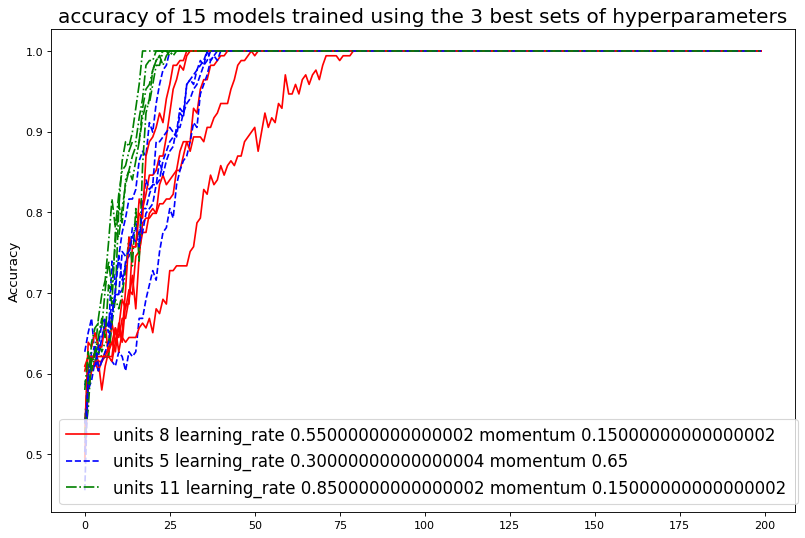

In [37]:
labels2 = [None]*n_hp2
for i in range(n_hp2):
    labels2[i] = ""
    for h_param in ["units", "learning_rate", "momentum"]:
        labels2[i] += h_param + " " + str(best_hp2[i].get(h_param)) + " "

colours = ["red", "blue", "green", "purple", "olive", "grey"]
linestyles = ["solid", "dashed", "dashdot", "dotted", (0, (1,1)), (5, (5, 10))]

plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials2):
    for j in range(n_hp2):
        plt.plot(hist2[j][i].history['accuracy'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "accuracy of " + str(n_hp2*n_trials2) + " models trained using the " + str(n_hp2) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Accuracy", size=12)
plt.legend(labels2, prop={'size': 15})
plt.savefig("./plots/monk2/nn_RandomSearch/ms_accuracy.png")
plt.show()

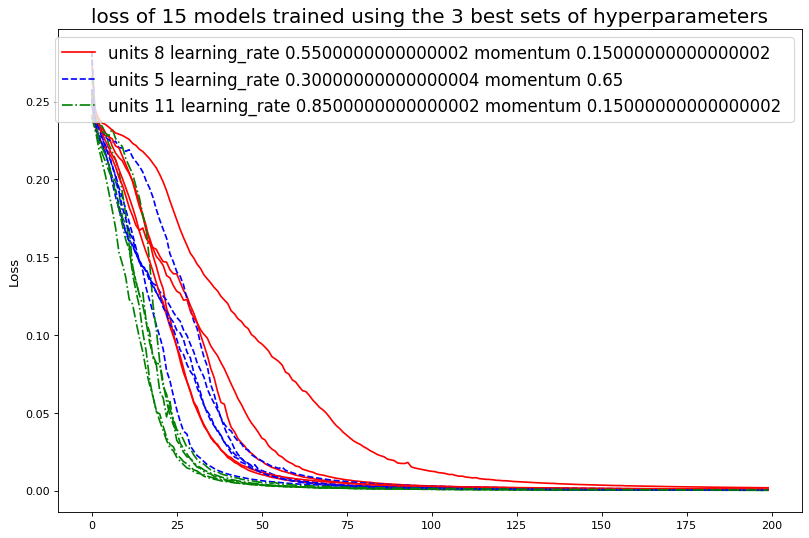

In [38]:
plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials2):
    for j in range(n_hp2):
        plt.plot(hist2[j][i].history['loss'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "loss of " + str(n_hp2*n_trials2) + " models trained using the " + str(n_hp2) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Loss", size=12)
plt.legend(labels2, prop={'size': 15})
plt.savefig("./plots/monk2/nn_RandomSearch/ms_loss.png")
plt.show()

In [39]:
print("Final accuracy reached for each of the " + str(n_hp2*n_trials2) + " models\n")

for i in range(n_hp2):
    print("set of hyperparameters n." + str(i) + ": " + labels2[i])
    for j in range(n_trials2):
        print(hist2[i][j].history['accuracy'][n_epochs2 - 1], end=" - ")
    print("\n")

Final accuracy reached for each of the 15 models

set of hyperparameters n.0: units 8 learning_rate 0.5500000000000002 momentum 0.15000000000000002 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.1: units 5 learning_rate 0.30000000000000004 momentum 0.65 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.2: units 11 learning_rate 0.8500000000000002 momentum 0.15000000000000002 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 



In [40]:
acc2 = None
best_acc2 = -1.0
best_model2 = None

for i in range(n_hp2):
    for j in range(n_trials2):
        acc2 = hist2[i][j].history['accuracy'][n_epochs2 - 1]
        if (acc2 > best_acc2):
            best_acc2 = acc2
            best_model2 = models2[i][j]
            
best_model2.save("results/monk2/nn_RandomSearch/final_model/")

INFO:tensorflow:Assets written to: results/monk2/nn_RandomSearch/final_model/assets


## Model Assessment ##

In [41]:
score2 = best_model2.evaluate(x_monk2_ts, y_monk2_ts)

14/14 [==============================] - 0s 1ms/step - loss: 8.2208e-04 - accuracy: 1.0000


In [42]:
print(
    "Final error (MSE) on the test set: " + str(score2[0]) + "\n" +
    "Final accuracy on the test set: " + str(score2[1])
)

Final error (MSE) on the test set: 0.0008220759336836636
Final accuracy on the test set: 1.0


# Monk3 #

In [75]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
monk3_tr = pd.read_csv("./dataset/monk3/monks-3.train", sep = " ", skipinitialspace=True, names = colnames)
monk3_tr = monk3_tr.drop('id', axis = 1)

monk3_ts = pd.read_csv("./dataset/monk3/monks-3.test", sep = " ", skipinitialspace=True, names = colnames)
monk3_ts = monk3_ts.drop('id', axis = 1)

In [76]:
x_monk3_tr = monk3_tr.iloc[:, 1:7].values
y_monk3_tr = monk3_tr.iloc[:, 0].values
x_monk3_ts = monk3_ts.iloc[:, 1:7].values
y_monk3_ts = monk3_ts.iloc[:, 0].values

In [77]:
one_hot_encoder_tr = OneHotEncoder(sparse=False)
one_hot_encoder_tr.fit(x_monk3_tr)
x_monk3_tr = one_hot_encoder_tr.transform(x_monk3_tr)

one_hot_encoder_ts = OneHotEncoder(sparse=False)
one_hot_encoder_ts.fit(x_monk3_ts)
x_monk3_ts = one_hot_encoder_ts.transform(x_monk3_ts)

x_monk3_tr, y_monk3_tr = shuffle(x_monk3_tr, y_monk3_tr)
x_monk3_ts, y_monk3_ts = shuffle(x_monk3_ts, y_monk3_ts)

In [78]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        return histories_cv

In [79]:
def set_hyperparameters(units, ridge_lambda, learning_rate, momentum):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L2(ridge_lambda),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid", activity_regularizer=regularizers.L2(ridge_lambda)))
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(
        optimizer=opt, loss="mse", metrics=['accuracy']
    )
    
    return model 





def build_model3(hp, min_units=2, max_units=11, min_ridge_lambda=0.0001, max_ridge_lambda=0.1,
                 min_lr_rate=0.1, max_lr_rate=0.6, min_mom=0.0, max_mom=0.9, linear_reg=False):
    
    ridge_lambda_sampling = "log"
    if(linear_reg):
        ridge_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units != min_units):
        units_step = 3
    
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    ridge_lambda = hp.Float(
        "ridge_lambda", min_value=min_ridge_lambda, max_value=max_ridge_lambda, sampling=ridge_lambda_sampling
    )
    learning_rate = hp.Float("learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling="linear")
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    model = set_hyperparameters(
        units=units, ridge_lambda=ridge_lambda, learning_rate=learning_rate, momentum=momentum
    )
    return model

In [80]:
tuner3 = CrossValidationRandomSearch(
    hypermodel=build_model3,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="results/monk3",
    project_name="nn_RandomSearch/par_hp",
    folds_number=3
)

In [81]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [82]:
tuner3.search(
    x_monk3_tr, y_monk3_tr, 
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
)

Trial 30 Complete [00h 00m 36s]
val_accuracy: 0.938617875178655

Best val_accuracy So Far: 0.938617875178655
Total elapsed time: 02h 35m 05s
INFO:tensorflow:Oracle triggered exit


In [83]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search

best hyperparameters n. 0
units 8
ridge_lambda 0.00019485843602263449
learning_rate 0.11566064235121079
momentum 0.25631839811782886

best hyperparameters n. 1
units 8
ridge_lambda 0.00012287029650385068
learning_rate 0.5574718206652562
momentum 0.23847044201393416

best hyperparameters n. 2
units 8
ridge_lambda 0.004546045850025048
learning_rate 0.2473500413078573
momentum 0.23165040521165803



In [84]:
f_model3 = build_model3(best_hp3[0])
f_model3.build(input_shape=(None, 17))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 144       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [85]:
tuner3.results_summary()

Results summary
Results in results/monk3/nn_RandomSearch/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00019485843602263449
learning_rate: 0.11566064235121079
momentum: 0.25631839811782886
Score: 0.938617875178655
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00012287029650385068
learning_rate: 0.5574718206652562
momentum: 0.23847044201393416
Score: 0.9304877916971842
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.004546045850025048
learning_rate: 0.2473500413078573
momentum: 0.23165040521165803
Score: 0.9304877916971842
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.0006783123695597306
learning_rate: 0.5296478261801449
momentum: 0.211971360899478
Score: 0.9304877916971842
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.05766988768807289
learning_rate: 0.46900700437892395
momentum: 0.1707188366627386
Score: 0.9304877916971842
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.005896077096467593
learning_ra

In [86]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
ridge_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])

ridge_lambda_min = (ridge_lambda / 10) * 9
ridge_lambda_max = (ridge_lambda / 10) * 11

learning_rate_min = (learning_rate / 10) * 9
learning_rate_max = (learning_rate / 10) * 11

momentum_min = (momentum / 10) * 9
momentum_max = (momentum / 10) * 11


x = lambda a: build_model3(
    a, min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_reg=True
)

tuner3 = CrossValidationRandomSearch(
    hypermodel=x,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="results/monk3",
    project_name="nn_RandomSearch/par_hp",
    folds_number=3
)

In [87]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.00017537259242037103, 'conditions': [], 'min_value': 0.00017537259242037103, 'max_value': 0.00021434427962489794, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.10409457811608971, 'conditions': [], 'min_value': 0.10409457811608971, 'max_value': 0.12722670658633187, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.23068655830604598, 'conditions': [], 'min_value': 0.23068655830604598, 'max_value': 0.28195023792961177, 'step': None, 'sampling': 'linear'}


In [88]:
tuner3.search(
    x_monk3_tr, y_monk3_tr, 
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
)

Trial 30 Complete [00h 00m 30s]
val_accuracy: 0.9138211210568746

Best val_accuracy So Far: 0.9345528384049734
Total elapsed time: 00h 18m 43s
INFO:tensorflow:Oracle triggered exit


In [89]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search

best hyperparameters n. 0
units 8
ridge_lambda 0.00021031790893349044
learning_rate 0.11153143979658764
momentum 0.24027722502172966

best hyperparameters n. 1
units 8
ridge_lambda 0.0002082269348129781
learning_rate 0.11066178154324442
momentum 0.2450835021567449

best hyperparameters n. 2
units 8
ridge_lambda 0.00019876879730393614
learning_rate 0.11468845658426617
momentum 0.23231835781304278



In [90]:
f_model3 = build_model3(best_hp3[0])
f_model3.build(
input_shape=(None, 17))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 144       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [91]:
tuner3.results_summary()

Results summary
Results in results/monk3/nn_RandomSearch/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00021031790893349044
learning_rate: 0.11153143979658764
momentum: 0.24027722502172966
Score: 0.9345528384049734
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.0002082269348129781
learning_rate: 0.11066178154324442
momentum: 0.2450835021567449
Score: 0.9345528384049734
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00019876879730393614
learning_rate: 0.11468845658426617
momentum: 0.23231835781304278
Score: 0.9345528284708658
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00018501797276144582
learning_rate: 0.10414649207257115
momentum: 0.256493921785628
Score: 0.9345528284708658
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.00017629127390730677
learning_rate: 0.10839781551798051
momentum: 0.24898637078525454
Score: 0.9304877916971842
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.0002037837201562955
l

In [92]:
subset_size = int(0.3 * len(x_monk3_tr))

index = np.random.choice(len(x_monk3_tr), subset_size, replace=False)
index = np.sort(index)

x_monk3_vl = x_monk3_tr[index]
y_monk3_vl = y_monk3_tr[index]

x_monk3_tr = np.delete(x_monk3_tr, index, 0)
y_monk3_tr = np.delete(y_monk3_tr, index, 0)

In [93]:
n_trials3 = 10

models3 = [None]*n_trials3

for i in range(n_trials3):
    models3[i] = build_model3(best_hp3[0])

n_epochs3 = 1000
hist3 = [None]*n_trials3

for i in range(n_trials3):
        hist3[i] = models3[i].fit(
            x=x_monk3_tr,
            y=y_monk3_tr,
            validation_data=(x_monk3_vl, y_monk3_vl),
            epochs=n_epochs3,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.2468 - accuracy: 0.6047 - val_loss: 0.2225 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2421 - accuracy: 0.6163 - val_loss: 0.2171 - val_accuracy: 0.7222
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2376 - accuracy: 0.6163 - val_loss: 0.2118 - val_accuracy: 0.7500
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2328 - accuracy: 0.6279 - val_loss: 0.2073 - val_accuracy: 0.6667
Epoch 5/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2285 - accuracy: 0.6395 - val_loss: 0.2029 - val_accuracy: 0.6667
Epoch 6/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2247 - accuracy: 0.6395 - val_loss: 0.1989 - val_accuracy: 0.6667
Epoch 7/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2205 - accuracy: 0.6744 - val_loss: 0.1952 - val_accuracy: 0.6944
Epoch 8/1000


Epoch 59/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0755 - accuracy: 0.9302 - val_loss: 0.0731 - val_accuracy: 0.9722
Epoch 60/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0746 - accuracy: 0.9302 - val_loss: 0.0722 - val_accuracy: 0.9722
Epoch 61/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0736 - accuracy: 0.9302 - val_loss: 0.0714 - val_accuracy: 0.9722
Epoch 62/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0729 - accuracy: 0.9302 - val_loss: 0.0707 - val_accuracy: 0.9722
Epoch 63/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0720 - accuracy: 0.9302 - val_loss: 0.0700 - val_accuracy: 0.9722
Epoch 64/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0714 - accuracy: 0.9302 - val_loss: 0.0694 - val_accuracy: 0.9722
Epoch 65/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0704 - accuracy: 0.9302 - val_loss: 0.0688 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 15ms/step - loss: 0.0471 - accuracy: 0.9535 - val_loss: 0.0543 - val_accuracy: 0.9722
Epoch 117/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0466 - accuracy: 0.9419 - val_loss: 0.0544 - val_accuracy: 0.9722
Epoch 118/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0465 - accuracy: 0.9535 - val_loss: 0.0542 - val_accuracy: 0.9722
Epoch 119/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0460 - accuracy: 0.9419 - val_loss: 0.0539 - val_accuracy: 0.9722
Epoch 120/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0458 - accuracy: 0.9535 - val_loss: 0.0539 - val_accuracy: 0.9722
Epoch 121/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0455 - accuracy: 0.9419 - val_loss: 0.0539 - val_accuracy: 0.9722
Epoch 122/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0453 - accuracy: 0.9535 - val_loss: 0.0538 - val_accuracy: 0.9722
Epoch 123/1000

Epoch 34/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1485 - accuracy: 0.8605 - val_loss: 0.1637 - val_accuracy: 0.8889
Epoch 35/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.1447 - accuracy: 0.8605 - val_loss: 0.1606 - val_accuracy: 0.8889
Epoch 36/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1424 - accuracy: 0.8605 - val_loss: 0.1578 - val_accuracy: 0.8889
Epoch 37/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1392 - accuracy: 0.8605 - val_loss: 0.1545 - val_accuracy: 0.8889
Epoch 38/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1365 - accuracy: 0.8605 - val_loss: 0.1514 - val_accuracy: 0.8889
Epoch 39/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1340 - accuracy: 0.8605 - val_loss: 0.1481 - val_accuracy: 0.8889
Epoch 40/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1311 - accuracy: 0.8605 - val_loss: 0.1444 - val_accuracy: 0.9167
Epoch 

Epoch 92/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0654 - accuracy: 0.9186 - val_loss: 0.0662 - val_accuracy: 0.9722
Epoch 93/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0647 - accuracy: 0.9186 - val_loss: 0.0660 - val_accuracy: 0.9722
Epoch 94/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0643 - accuracy: 0.9186 - val_loss: 0.0655 - val_accuracy: 0.9722
Epoch 95/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0636 - accuracy: 0.9186 - val_loss: 0.0651 - val_accuracy: 0.9722
Epoch 96/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0631 - accuracy: 0.9186 - val_loss: 0.0648 - val_accuracy: 0.9722
Epoch 97/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0630 - accuracy: 0.9302 - val_loss: 0.0641 - val_accuracy: 0.9722
Epoch 98/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0622 - accuracy: 0.9302 - val_loss: 0.0634 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 0.0464 - accuracy: 0.9419 - val_loss: 0.0536 - val_accuracy: 0.9722
Epoch 150/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0458 - accuracy: 0.9419 - val_loss: 0.0535 - val_accuracy: 0.9722
Epoch 151/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0457 - accuracy: 0.9419 - val_loss: 0.0528 - val_accuracy: 0.9722
Epoch 152/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0456 - accuracy: 0.9419 - val_loss: 0.0528 - val_accuracy: 0.9722
Epoch 153/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0452 - accuracy: 0.9419 - val_loss: 0.0534 - val_accuracy: 0.9722
Epoch 154/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0454 - accuracy: 0.9419 - val_loss: 0.0535 - val_accuracy: 0.9722
Epoch 155/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0450 - accuracy: 0.9419 - val_loss: 0.0528 - val_accuracy: 0.9722
Epoch 156/1000

3/3 [==============================] - 0s 17ms/step - loss: 0.1988 - accuracy: 0.7326 - val_loss: 0.1835 - val_accuracy: 0.7500
Epoch 14/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.1955 - accuracy: 0.7674 - val_loss: 0.1799 - val_accuracy: 0.7500
Epoch 15/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1912 - accuracy: 0.7674 - val_loss: 0.1762 - val_accuracy: 0.8056
Epoch 16/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.1881 - accuracy: 0.7674 - val_loss: 0.1735 - val_accuracy: 0.8056
Epoch 17/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1840 - accuracy: 0.7674 - val_loss: 0.1713 - val_accuracy: 0.8056
Epoch 18/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1805 - accuracy: 0.7674 - val_loss: 0.1691 - val_accuracy: 0.8333
Epoch 19/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1767 - accuracy: 0.7674 - val_loss: 0.1668 - val_accuracy: 0.8333
Epoch 20/1000
3/3 [=

Epoch 71/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0715 - accuracy: 0.9302 - val_loss: 0.0662 - val_accuracy: 0.9722
Epoch 72/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0712 - accuracy: 0.9302 - val_loss: 0.0657 - val_accuracy: 0.9722
Epoch 73/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0702 - accuracy: 0.9302 - val_loss: 0.0653 - val_accuracy: 0.9722
Epoch 74/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0699 - accuracy: 0.9302 - val_loss: 0.0645 - val_accuracy: 0.9722
Epoch 75/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0695 - accuracy: 0.9302 - val_loss: 0.0636 - val_accuracy: 0.9722
Epoch 76/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0689 - accuracy: 0.9302 - val_loss: 0.0631 - val_accuracy: 0.9722
Epoch 77/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0682 - accuracy: 0.9302 - val_loss: 0.0628 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 0.0536 - accuracy: 0.9419 - val_loss: 0.0561 - val_accuracy: 0.9722
Epoch 129/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0535 - accuracy: 0.9419 - val_loss: 0.0560 - val_accuracy: 0.9722
Epoch 1/1000
3/3 [==============================] - 1s 72ms/step - loss: 0.2897 - accuracy: 0.5116 - val_loss: 0.3114 - val_accuracy: 0.3611
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2815 - accuracy: 0.5116 - val_loss: 0.3012 - val_accuracy: 0.3611
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2743 - accuracy: 0.5116 - val_loss: 0.2922 - val_accuracy: 0.3889
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2679 - accuracy: 0.5116 - val_loss: 0.2843 - val_accuracy: 0.4167
Epoch 5/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2625 - accuracy: 0.5000 - val_loss: 0.2778 - val_accuracy: 0.4167
Epoch 6/1000
3/3 [======

Epoch 57/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.1146 - accuracy: 0.9419 - val_loss: 0.1197 - val_accuracy: 0.9167
Epoch 58/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.1120 - accuracy: 0.9419 - val_loss: 0.1177 - val_accuracy: 0.9167
Epoch 59/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1101 - accuracy: 0.9419 - val_loss: 0.1151 - val_accuracy: 0.9167
Epoch 60/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.9419 - val_loss: 0.1121 - val_accuracy: 0.9444
Epoch 61/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1061 - accuracy: 0.9535 - val_loss: 0.1095 - val_accuracy: 0.9722
Epoch 62/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1047 - accuracy: 0.9535 - val_loss: 0.1079 - val_accuracy: 0.9722
Epoch 63/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1030 - accuracy: 0.9535 - val_loss: 0.1067 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 19ms/step - loss: 0.0647 - accuracy: 0.9419 - val_loss: 0.0635 - val_accuracy: 0.9722
Epoch 115/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0640 - accuracy: 0.9419 - val_loss: 0.0626 - val_accuracy: 0.9722
Epoch 116/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0636 - accuracy: 0.9419 - val_loss: 0.0625 - val_accuracy: 0.9722
Epoch 117/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0633 - accuracy: 0.9419 - val_loss: 0.0627 - val_accuracy: 0.9722
Epoch 118/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0629 - accuracy: 0.9419 - val_loss: 0.0626 - val_accuracy: 0.9722
Epoch 119/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0628 - accuracy: 0.9419 - val_loss: 0.0620 - val_accuracy: 0.9722
Epoch 120/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0624 - accuracy: 0.9419 - val_loss: 0.0618 - val_accuracy: 0.9722
Epoch 121/1000

3/3 [==============================] - 0s 16ms/step - loss: 0.1330 - accuracy: 0.9186 - val_loss: 0.1247 - val_accuracy: 0.9444
Epoch 30/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1297 - accuracy: 0.9302 - val_loss: 0.1208 - val_accuracy: 0.9722
Epoch 31/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1266 - accuracy: 0.9186 - val_loss: 0.1173 - val_accuracy: 0.9722
Epoch 32/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1233 - accuracy: 0.9186 - val_loss: 0.1142 - val_accuracy: 0.9722
Epoch 33/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.9302 - val_loss: 0.1117 - val_accuracy: 0.9722
Epoch 34/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1176 - accuracy: 0.9302 - val_loss: 0.1089 - val_accuracy: 0.9722
Epoch 35/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1149 - accuracy: 0.9419 - val_loss: 0.1062 - val_accuracy: 0.9722
Epoch 36/1000
3/3 [=

Epoch 87/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0584 - accuracy: 0.9186 - val_loss: 0.0546 - val_accuracy: 0.9722
Epoch 88/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0578 - accuracy: 0.9302 - val_loss: 0.0543 - val_accuracy: 0.9722
Epoch 89/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0576 - accuracy: 0.9186 - val_loss: 0.0542 - val_accuracy: 0.9722
Epoch 90/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0572 - accuracy: 0.9302 - val_loss: 0.0540 - val_accuracy: 0.9722
Epoch 91/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0567 - accuracy: 0.9302 - val_loss: 0.0536 - val_accuracy: 0.9722
Epoch 92/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0565 - accuracy: 0.9302 - val_loss: 0.0531 - val_accuracy: 0.9722
Epoch 93/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0561 - accuracy: 0.9302 - val_loss: 0.0528 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 0.0419 - accuracy: 0.9535 - val_loss: 0.0466 - val_accuracy: 0.9722
Epoch 145/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0416 - accuracy: 0.9535 - val_loss: 0.0465 - val_accuracy: 0.9722
Epoch 146/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0414 - accuracy: 0.9535 - val_loss: 0.0464 - val_accuracy: 0.9722
Epoch 147/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0413 - accuracy: 0.9535 - val_loss: 0.0463 - val_accuracy: 0.9722
Epoch 148/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0410 - accuracy: 0.9535 - val_loss: 0.0464 - val_accuracy: 0.9722
Epoch 149/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0408 - accuracy: 0.9535 - val_loss: 0.0463 - val_accuracy: 0.9722
Epoch 150/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0406 - accuracy: 0.9535 - val_loss: 0.0463 - val_accuracy: 0.9722
Epoch 151/1000

3/3 [==============================] - 0s 16ms/step - loss: 0.0326 - accuracy: 0.9535 - val_loss: 0.0450 - val_accuracy: 0.9722
Epoch 202/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0324 - accuracy: 0.9535 - val_loss: 0.0450 - val_accuracy: 0.9722
Epoch 203/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0322 - accuracy: 0.9535 - val_loss: 0.0446 - val_accuracy: 0.9722
Epoch 204/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0321 - accuracy: 0.9535 - val_loss: 0.0447 - val_accuracy: 0.9722
Epoch 205/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0319 - accuracy: 0.9535 - val_loss: 0.0447 - val_accuracy: 0.9722
Epoch 206/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0319 - accuracy: 0.9535 - val_loss: 0.0445 - val_accuracy: 0.9722
Epoch 207/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0317 - accuracy: 0.9535 - val_loss: 0.0445 - val_accuracy: 0.9722
Epoch 208/1000

Epoch 33/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1628 - accuracy: 0.8140 - val_loss: 0.1628 - val_accuracy: 0.8333
Epoch 34/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1596 - accuracy: 0.8140 - val_loss: 0.1599 - val_accuracy: 0.8611
Epoch 35/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1564 - accuracy: 0.8256 - val_loss: 0.1574 - val_accuracy: 0.8611
Epoch 36/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1535 - accuracy: 0.8488 - val_loss: 0.1545 - val_accuracy: 0.8889
Epoch 37/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1500 - accuracy: 0.8488 - val_loss: 0.1515 - val_accuracy: 0.8889
Epoch 38/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1471 - accuracy: 0.8488 - val_loss: 0.1485 - val_accuracy: 0.8889
Epoch 39/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.1435 - accuracy: 0.8488 - val_loss: 0.1454 - val_accuracy: 0.8889
Epoch 

Epoch 91/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0712 - accuracy: 0.9186 - val_loss: 0.0714 - val_accuracy: 0.9722
Epoch 92/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0709 - accuracy: 0.9186 - val_loss: 0.0710 - val_accuracy: 0.9722
Epoch 93/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0702 - accuracy: 0.9186 - val_loss: 0.0710 - val_accuracy: 0.9722
Epoch 94/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0698 - accuracy: 0.9186 - val_loss: 0.0706 - val_accuracy: 0.9722
Epoch 95/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0698 - accuracy: 0.9186 - val_loss: 0.0705 - val_accuracy: 0.9722
Epoch 96/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0698 - accuracy: 0.9186 - val_loss: 0.0699 - val_accuracy: 0.9722
Epoch 97/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0688 - accuracy: 0.9186 - val_loss: 0.0690 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 65ms/step - loss: 0.2792 - accuracy: 0.4767 - val_loss: 0.2660 - val_accuracy: 0.5000
Epoch 2/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2705 - accuracy: 0.4419 - val_loss: 0.2600 - val_accuracy: 0.4722
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2630 - accuracy: 0.4651 - val_loss: 0.2555 - val_accuracy: 0.4722
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2572 - accuracy: 0.4419 - val_loss: 0.2516 - val_accuracy: 0.4444
Epoch 5/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.2525 - accuracy: 0.4419 - val_loss: 0.2487 - val_accuracy: 0.4444
Epoch 6/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2483 - accuracy: 0.5116 - val_loss: 0.2463 - val_accuracy: 0.4444
Epoch 7/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2447 - accuracy: 0.5349 - val_loss: 0.2441 - val_accuracy: 0.4722
Epoch 8/1000
3/3 [========

Epoch 59/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1058 - accuracy: 0.9186 - val_loss: 0.1075 - val_accuracy: 0.9444
Epoch 60/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1042 - accuracy: 0.9186 - val_loss: 0.1053 - val_accuracy: 0.9444
Epoch 61/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1020 - accuracy: 0.9302 - val_loss: 0.1030 - val_accuracy: 0.9444
Epoch 62/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1006 - accuracy: 0.9302 - val_loss: 0.1012 - val_accuracy: 0.9444
Epoch 63/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0992 - accuracy: 0.9302 - val_loss: 0.0993 - val_accuracy: 0.9444
Epoch 64/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0975 - accuracy: 0.9302 - val_loss: 0.0976 - val_accuracy: 0.9444
Epoch 65/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9302 - val_loss: 0.0959 - val_accuracy: 0.9444
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 0.0621 - accuracy: 0.9302 - val_loss: 0.0580 - val_accuracy: 0.9444
Epoch 117/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0619 - accuracy: 0.9302 - val_loss: 0.0581 - val_accuracy: 0.9444
Epoch 118/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0616 - accuracy: 0.9302 - val_loss: 0.0582 - val_accuracy: 0.9444
Epoch 119/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0613 - accuracy: 0.9302 - val_loss: 0.0583 - val_accuracy: 0.9444
Epoch 120/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0611 - accuracy: 0.9302 - val_loss: 0.0584 - val_accuracy: 0.9444
Epoch 121/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0610 - accuracy: 0.9302 - val_loss: 0.0582 - val_accuracy: 0.9444
Epoch 122/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0604 - accuracy: 0.9302 - val_loss: 0.0579 - val_accuracy: 0.9444
Epoch 123/1000

3/3 [==============================] - 0s 15ms/step - loss: 0.2675 - accuracy: 0.5349 - val_loss: 0.2725 - val_accuracy: 0.5278
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2589 - accuracy: 0.5349 - val_loss: 0.2649 - val_accuracy: 0.5000
Epoch 4/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2512 - accuracy: 0.5814 - val_loss: 0.2587 - val_accuracy: 0.5000
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2447 - accuracy: 0.6047 - val_loss: 0.2528 - val_accuracy: 0.5278
Epoch 6/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2385 - accuracy: 0.6279 - val_loss: 0.2471 - val_accuracy: 0.5278
Epoch 7/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2336 - accuracy: 0.6279 - val_loss: 0.2420 - val_accuracy: 0.5556
Epoch 8/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2275 - accuracy: 0.6395 - val_loss: 0.2376 - val_accuracy: 0.5556
Epoch 9/1000
3/3 [========

Epoch 60/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0807 - accuracy: 0.9419 - val_loss: 0.0831 - val_accuracy: 0.9444
Epoch 61/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0795 - accuracy: 0.9419 - val_loss: 0.0820 - val_accuracy: 0.9444
Epoch 62/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0783 - accuracy: 0.9419 - val_loss: 0.0806 - val_accuracy: 0.9444
Epoch 63/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0772 - accuracy: 0.9419 - val_loss: 0.0793 - val_accuracy: 0.9444
Epoch 64/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0764 - accuracy: 0.9419 - val_loss: 0.0781 - val_accuracy: 0.9722
Epoch 65/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0755 - accuracy: 0.9419 - val_loss: 0.0763 - val_accuracy: 0.9722
Epoch 66/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0743 - accuracy: 0.9419 - val_loss: 0.0753 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 15ms/step - loss: 0.0497 - accuracy: 0.9419 - val_loss: 0.0605 - val_accuracy: 0.9444
Epoch 118/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0495 - accuracy: 0.9419 - val_loss: 0.0611 - val_accuracy: 0.9444
Epoch 119/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0490 - accuracy: 0.9419 - val_loss: 0.0611 - val_accuracy: 0.9444
Epoch 120/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0488 - accuracy: 0.9419 - val_loss: 0.0605 - val_accuracy: 0.9444
Epoch 121/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0486 - accuracy: 0.9419 - val_loss: 0.0599 - val_accuracy: 0.9444
Epoch 122/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0483 - accuracy: 0.9419 - val_loss: 0.0596 - val_accuracy: 0.9444
Epoch 123/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0483 - accuracy: 0.9419 - val_loss: 0.0601 - val_accuracy: 0.9444
Epoch 124/1000

3/3 [==============================] - 0s 15ms/step - loss: 0.1666 - accuracy: 0.8488 - val_loss: 0.1723 - val_accuracy: 0.8611
Epoch 26/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1624 - accuracy: 0.8605 - val_loss: 0.1681 - val_accuracy: 0.8611
Epoch 27/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1596 - accuracy: 0.8605 - val_loss: 0.1645 - val_accuracy: 0.8611
Epoch 28/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1554 - accuracy: 0.8837 - val_loss: 0.1607 - val_accuracy: 0.8611
Epoch 29/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1522 - accuracy: 0.8837 - val_loss: 0.1570 - val_accuracy: 0.8611
Epoch 30/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1484 - accuracy: 0.8953 - val_loss: 0.1533 - val_accuracy: 0.8611
Epoch 31/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1452 - accuracy: 0.8953 - val_loss: 0.1499 - val_accuracy: 0.8611
Epoch 32/1000
3/3 [=

Epoch 83/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0685 - accuracy: 0.9302 - val_loss: 0.0649 - val_accuracy: 0.9722
Epoch 84/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0684 - accuracy: 0.9302 - val_loss: 0.0640 - val_accuracy: 0.9722
Epoch 85/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0677 - accuracy: 0.9302 - val_loss: 0.0634 - val_accuracy: 0.9722
Epoch 86/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0673 - accuracy: 0.9186 - val_loss: 0.0632 - val_accuracy: 0.9722
Epoch 87/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0669 - accuracy: 0.9302 - val_loss: 0.0628 - val_accuracy: 0.9722
Epoch 88/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0666 - accuracy: 0.9302 - val_loss: 0.0625 - val_accuracy: 0.9722
Epoch 89/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0662 - accuracy: 0.9186 - val_loss: 0.0624 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 0.2235 - accuracy: 0.6163 - val_loss: 0.2247 - val_accuracy: 0.7222
Epoch 13/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2216 - accuracy: 0.6628 - val_loss: 0.2223 - val_accuracy: 0.7500
Epoch 14/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.2191 - accuracy: 0.6744 - val_loss: 0.2199 - val_accuracy: 0.7500
Epoch 15/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2171 - accuracy: 0.6860 - val_loss: 0.2175 - val_accuracy: 0.7778
Epoch 16/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2148 - accuracy: 0.7093 - val_loss: 0.2151 - val_accuracy: 0.7778
Epoch 17/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.2125 - accuracy: 0.7093 - val_loss: 0.2125 - val_accuracy: 0.8056
Epoch 18/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2101 - accuracy: 0.7442 - val_loss: 0.2097 - val_accuracy: 0.8056
Epoch 19/1000
3/3 [=

Epoch 70/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0878 - accuracy: 0.9186 - val_loss: 0.0758 - val_accuracy: 0.9722
Epoch 71/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0865 - accuracy: 0.9186 - val_loss: 0.0745 - val_accuracy: 0.9722
Epoch 72/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0852 - accuracy: 0.9186 - val_loss: 0.0734 - val_accuracy: 0.9722
Epoch 73/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0841 - accuracy: 0.9186 - val_loss: 0.0722 - val_accuracy: 0.9722
Epoch 74/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0829 - accuracy: 0.9186 - val_loss: 0.0710 - val_accuracy: 0.9722
Epoch 75/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0820 - accuracy: 0.9186 - val_loss: 0.0703 - val_accuracy: 0.9722
Epoch 76/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0809 - accuracy: 0.9186 - val_loss: 0.0697 - val_accuracy: 0.9722
Epoch 

3/3 [==============================] - 0s 18ms/step - loss: 0.0562 - accuracy: 0.9302 - val_loss: 0.0530 - val_accuracy: 0.9722
Epoch 128/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0557 - accuracy: 0.9302 - val_loss: 0.0531 - val_accuracy: 0.9722
Epoch 129/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0556 - accuracy: 0.9302 - val_loss: 0.0532 - val_accuracy: 0.9722
Epoch 130/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0554 - accuracy: 0.9302 - val_loss: 0.0530 - val_accuracy: 0.9722
Epoch 131/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0551 - accuracy: 0.9302 - val_loss: 0.0527 - val_accuracy: 0.9722
Epoch 132/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0549 - accuracy: 0.9302 - val_loss: 0.0527 - val_accuracy: 0.9722
Epoch 133/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0550 - accuracy: 0.9302 - val_loss: 0.0525 - val_accuracy: 0.9722
Epoch 134/1000

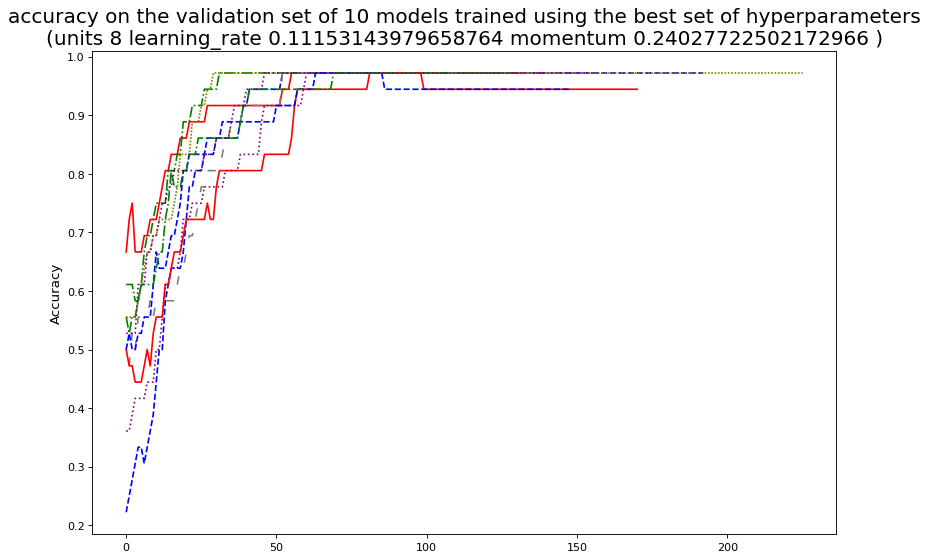

In [94]:
labels3 = [None]
labels3 = ""
for h_param in ["units", "learning_rate", "momentum"]:
    labels3 += h_param + " " + str(best_hp3[0].get(h_param)) + " "

list_values = [None]*n_trials3

colours = ["red", "blue", "green", "purple", "olive", "grey"]
linestyles = ["solid", "dashed", "dashdot", "dotted", (0, (1,1)), (5, (5, 10))]

for i in range(n_trials3):
    list_values[i] = hist3[i].history['val_accuracy']

max_length = 0
for i in range(n_trials3):
    if (max_length < len(list_values[i])):
        max_length = len(list_values[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials3):
    plt.plot(
        time_ep[0:len(list_values[i])], list_values[i],
        color=colours[i%len(colours)], linestyle=linestyles[i%len(linestyles)])

plt.title(
    "accuracy on the validation set of " + str(n_trials3) + 
    " models trained using the best set of hyperparameters\n("
    + labels3 + ")", size=18
)

plt.ylabel("Accuracy", size=12)
plt.savefig("./plots/monk3/nn_RandomSearch/ms_accuracy.png")
plt.show()

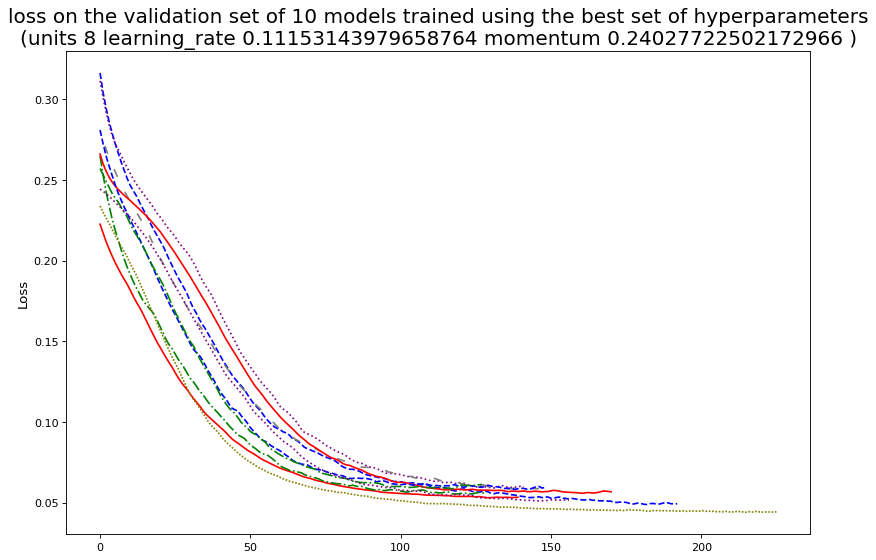

In [95]:
list_values2 = [None]*n_trials3

colours = ["red", "blue", "green", "purple", "olive", "grey"]
linestyles = ["solid", "dashed", "dashdot", "dotted", (0, (1,1)), (5, (5, 10))]

for i in range(n_trials3):
    list_values2[i] = hist3[i].history['val_loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials3):
    plt.plot(
        time_ep[0:len(list_values2[i])], list_values2[i],
        color=colours[i%len(colours)], linestyle=linestyles[i%len(linestyles)])

plt.title(
    "loss on the validation set of " + str(n_trials3) + 
    " models trained using the best set of hyperparameters\n("
    + labels3 + ")", size=18
)

plt.ylabel("Loss", size=12)
plt.savefig("./plots/monk3/nn_RandomSearch/ms_loss.png")
plt.show()

In [96]:
final_values = [None]*n_trials3
for i in range(n_trials3):
    final_values[i] = list_values[i][len(list_values[i]) - 1]

list_scores = [None]*n_trials3
for i in range(n_trials3):
    list_scores[i] = [final_values[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

index = list_scores[int(n_trials3/2)][1]

avg_model = models3[index]
avg_model.save("results/monk3/nn_RandomSearch/final_model/")

INFO:tensorflow:Assets written to: results/monk3/nn_RandomSearch/final_model/assets


## Model Assessment ##

In [97]:
score3 = avg_model.evaluate(x_monk3_ts, y_monk3_ts)

14/14 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9514


In [98]:
print(
    "Final error (MSE) on the test set: " + str(score3[0]) + "\n" +
    "Final accuracy on the test set: " + str(score3[1])
)

Final error (MSE) on the test set: 0.06102990731596947
Final accuracy on the test set: 0.9513888955116272
